# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

Setting ds_accelerator to cuda (auto detect)


2023-09-22 18:52:03.333024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 18:52:03.940263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 50
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2222445
Valid Tokens:  243937
Test Tokens:  279249
Total number of tokens: 2745631


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 33264


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:

train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)


# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 39.309264



H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0:   0%|          | 0/1778 [00:00<?, ?batch/s]

Epoch 0: 100%|██████████| 1778/1778 [01:59<00:00, 14.84batch/s, loss=6.19, perplexity=784]    


Valid: Loss = 5.253 Perplexity= 200.9, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1778/1778 [01:59<00:00, 14.85batch/s, loss=5.58, perplexity=274]


Valid: Loss = 5.002 Perplexity= 155.7, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1778/1778 [02:00<00:00, 14.75batch/s, loss=5.34, perplexity=216]


Valid: Loss = 4.863 Perplexity= 135.3, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1778/1778 [01:59<00:00, 14.93batch/s, loss=5.17, perplexity=182]


Valid: Loss = 4.755 Perplexity= 121.4, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1778/1778 [01:59<00:00, 14.84batch/s, loss=5.02, perplexity=157]


Valid: Loss = 4.663 Perplexity= 110.7, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1778/1778 [02:00<00:00, 14.73batch/s, loss=4.9, perplexity=140] 


Valid: Loss = 4.607 Perplexity= 104.6, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1778/1778 [01:59<00:00, 14.83batch/s, loss=4.8, perplexity=127] 


Valid: Loss = 4.566 Perplexity= 100.5, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1778/1778 [01:58<00:00, 14.97batch/s, loss=4.71, perplexity=116]


Valid: Loss = 4.53 Perplexity= 97.02, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1778/1778 [02:00<00:00, 14.76batch/s, loss=4.63, perplexity=107]


Valid: Loss = 4.494 Perplexity= 93.63, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1778/1778 [02:00<00:00, 14.75batch/s, loss=4.56, perplexity=99.9]


Valid: Loss = 4.452 Perplexity= 89.95, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1778/1778 [02:00<00:00, 14.77batch/s, loss=4.5, perplexity=93.8] 


Valid: Loss = 4.438 Perplexity= 88.68, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1778/1778 [01:59<00:00, 14.89batch/s, loss=4.43, perplexity=87.7]


Valid: Loss = 4.4 Perplexity= 85.49, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1778/1778 [02:00<00:00, 14.78batch/s, loss=4.37, perplexity=82.2]


Valid: Loss = 4.362 Perplexity= 82.34, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1778/1778 [02:00<00:00, 14.81batch/s, loss=4.31, perplexity=77.7]


Valid: Loss = 4.317 Perplexity= 78.65, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1778/1778 [02:00<00:00, 14.71batch/s, loss=4.25, perplexity=73.4]


Valid: Loss = 4.291 Perplexity= 76.67, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 1778/1778 [01:59<00:00, 14.83batch/s, loss=4.2, perplexity=69.9] 


Valid: Loss = 4.279 Perplexity= 75.82, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 1778/1778 [01:59<00:00, 14.90batch/s, loss=4.15, perplexity=65.9]


Valid: Loss = 4.243 Perplexity= 73.11, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 1778/1778 [01:58<00:00, 14.98batch/s, loss=4.1, perplexity=62.8] 


Valid: Loss = 4.205 Perplexity= 70.36, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 1778/1778 [01:49<00:00, 16.20batch/s, loss=4.05, perplexity=59.9]


Valid: Loss = 4.157 Perplexity= 67.07, LR = 0.5
Model Saved!



Epoch 19: 100%|██████████| 1778/1778 [01:49<00:00, 16.24batch/s, loss=3.99, perplexity=56.6]


Valid: Loss = 4.144 Perplexity= 66.11, LR = 0.5
Model Saved!



Epoch 20: 100%|██████████| 1778/1778 [01:49<00:00, 16.22batch/s, loss=3.95, perplexity=54.2]


Valid: Loss = 4.106 Perplexity= 63.73, LR = 0.5
Model Saved!



Epoch 21: 100%|██████████| 1778/1778 [01:49<00:00, 16.24batch/s, loss=3.91, perplexity=51.9]


Valid: Loss = 4.085 Perplexity= 62.26, LR = 0.5
Model Saved!



Epoch 22: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.87, perplexity=49.8]


Valid: Loss = 4.063 Perplexity= 60.87, LR = 0.5
Model Saved!



Epoch 23: 100%|██████████| 1778/1778 [01:49<00:00, 16.23batch/s, loss=3.83, perplexity=47.8]


Valid: Loss = 4.042 Perplexity= 59.69, LR = 0.5
Model Saved!



Epoch 24: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.79, perplexity=46.2]


Valid: Loss = 4.05 Perplexity= 60.11, LR = 0.5



Epoch 25: 100%|██████████| 1778/1778 [01:49<00:00, 16.20batch/s, loss=3.65, perplexity=40]  


Valid: Loss = 3.93 Perplexity= 53.43, LR = 0.25
Model Saved!



Epoch 26: 100%|██████████| 1778/1778 [01:49<00:00, 16.19batch/s, loss=3.57, perplexity=36.9]


Valid: Loss = 3.885 Perplexity= 51.06, LR = 0.25
Model Saved!



Epoch 27: 100%|██████████| 1778/1778 [01:49<00:00, 16.19batch/s, loss=3.52, perplexity=35.1]


Valid: Loss = 3.841 Perplexity= 48.83, LR = 0.25
Model Saved!



Epoch 28: 100%|██████████| 1778/1778 [01:49<00:00, 16.20batch/s, loss=3.48, perplexity=33.8]


Valid: Loss = 3.827 Perplexity= 48.2, LR = 0.25
Model Saved!



Epoch 29: 100%|██████████| 1778/1778 [01:49<00:00, 16.18batch/s, loss=3.45, perplexity=32.7]


Valid: Loss = 3.8 Perplexity= 46.92, LR = 0.25
Model Saved!



Epoch 30: 100%|██████████| 1778/1778 [01:49<00:00, 16.17batch/s, loss=3.41, perplexity=31.6]


Valid: Loss = 3.814 Perplexity= 47.68, LR = 0.25



Epoch 31: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.33, perplexity=29]  


Valid: Loss = 3.687 Perplexity= 41.84, LR = 0.125
Model Saved!



Epoch 32: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.27, perplexity=27.4]


Valid: Loss = 3.669 Perplexity= 41.12, LR = 0.125
Model Saved!



Epoch 33: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.24, perplexity=26.6]


Valid: Loss = 3.644 Perplexity= 40.07, LR = 0.125
Model Saved!



Epoch 34: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.21, perplexity=25.8]


Valid: Loss = 3.633 Perplexity= 39.61, LR = 0.125
Model Saved!



Epoch 35: 100%|██████████| 1778/1778 [01:49<00:00, 16.22batch/s, loss=3.19, perplexity=25.3]


Valid: Loss = 3.619 Perplexity= 39.09, LR = 0.125
Model Saved!



Epoch 36: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.17, perplexity=24.7]


Valid: Loss = 3.611 Perplexity= 38.77, LR = 0.125
Model Saved!



Epoch 37: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.15, perplexity=24.2]


Valid: Loss = 3.57 Perplexity= 37.18, LR = 0.125
Model Saved!



Epoch 38: 100%|██████████| 1778/1778 [01:49<00:00, 16.22batch/s, loss=3.13, perplexity=23.7]


Valid: Loss = 3.585 Perplexity= 37.78, LR = 0.125



Epoch 39: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.07, perplexity=22.4]


Valid: Loss = 3.52 Perplexity= 35.33, LR = 0.0625
Model Saved!



Epoch 40: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.04, perplexity=21.6]


Valid: Loss = 3.509 Perplexity= 34.95, LR = 0.0625
Model Saved!



Epoch 41: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3.01, perplexity=21.1]


Valid: Loss = 3.501 Perplexity= 34.71, LR = 0.0625
Model Saved!



Epoch 42: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=3, perplexity=20.7]   


Valid: Loss = 3.481 Perplexity= 33.98, LR = 0.0625
Model Saved!



Epoch 43: 100%|██████████| 1778/1778 [01:49<00:00, 16.20batch/s, loss=2.98, perplexity=20.4]


Valid: Loss = 3.465 Perplexity= 33.46, LR = 0.0625
Model Saved!



Epoch 44: 100%|██████████| 1778/1778 [01:49<00:00, 16.21batch/s, loss=2.97, perplexity=20.1]


Valid: Loss = 3.452 Perplexity= 33.0, LR = 0.0625
Model Saved!



Epoch 45: 100%|██████████| 1778/1778 [01:56<00:00, 15.27batch/s, loss=2.95, perplexity=19.8]


Valid: Loss = 3.453 Perplexity= 33.03, LR = 0.0625



Epoch 46: 100%|██████████| 1778/1778 [01:59<00:00, 14.92batch/s, loss=2.93, perplexity=19.3]


Valid: Loss = 3.4 Perplexity= 31.31, LR = 0.03125
Model Saved!



Epoch 47: 100%|██████████| 1778/1778 [02:00<00:00, 14.80batch/s, loss=2.91, perplexity=18.9]


Valid: Loss = 3.376 Perplexity= 30.57, LR = 0.03125
Model Saved!



Epoch 48: 100%|██████████| 1778/1778 [01:56<00:00, 15.21batch/s, loss=2.89, perplexity=18.7]


Valid: Loss = 3.374 Perplexity= 30.52, LR = 0.03125
Model Saved!



Epoch 49: 100%|██████████| 1778/1778 [01:56<00:00, 15.32batch/s, loss=2.88, perplexity=18.5]


Valid: Loss = 3.353 Perplexity= 29.87, LR = 0.03125
Model Saved!



Epoch 50: 100%|██████████| 1778/1778 [01:54<00:00, 15.50batch/s, loss=2.87, perplexity=18.2]


Valid: Loss = 3.354 Perplexity= 29.89, LR = 0.03125



Epoch 51: 100%|██████████| 1778/1778 [03:45<00:00,  7.88batch/s, loss=2.87, perplexity=18.2]


Valid: Loss = 3.311 Perplexity= 28.63, LR = 0.015625
Model Saved!



Epoch 52: 100%|██████████| 1778/1778 [03:51<00:00,  7.67batch/s, loss=2.86, perplexity=18]  


Valid: Loss = 3.301 Perplexity= 28.35, LR = 0.015625
Model Saved!



Epoch 53: 100%|██████████| 1778/1778 [03:51<00:00,  7.68batch/s, loss=2.85, perplexity=17.8]


Valid: Loss = 3.291 Perplexity= 28.06, LR = 0.015625
Model Saved!



Epoch 54: 100%|██████████| 1778/1778 [03:49<00:00,  7.74batch/s, loss=2.84, perplexity=17.6]


Valid: Loss = 3.287 Perplexity= 27.93, LR = 0.015625
Model Saved!



Epoch 55: 100%|██████████| 1778/1778 [03:52<00:00,  7.65batch/s, loss=2.83, perplexity=17.5]


Valid: Loss = 3.275 Perplexity= 27.6, LR = 0.015625
Model Saved!



Epoch 56: 100%|██████████| 1778/1778 [03:54<00:00,  7.60batch/s, loss=2.82, perplexity=17.3]


Valid: Loss = 3.277 Perplexity= 27.65, LR = 0.015625



Epoch 57: 100%|██████████| 1778/1778 [03:48<00:00,  7.77batch/s, loss=2.82, perplexity=17.4]


Valid: Loss = 3.244 Perplexity= 26.71, LR = 0.0078125
Model Saved!



Epoch 58: 100%|██████████| 1778/1778 [03:53<00:00,  7.60batch/s, loss=2.81, perplexity=17.2]


Valid: Loss = 3.238 Perplexity= 26.57, LR = 0.0078125
Model Saved!



Epoch 59: 100%|██████████| 1778/1778 [03:54<00:00,  7.58batch/s, loss=2.81, perplexity=17.2]


Valid: Loss = 3.233 Perplexity= 26.43, LR = 0.0078125
Model Saved!



Epoch 60: 100%|██████████| 1778/1778 [03:50<00:00,  7.72batch/s, loss=2.8, perplexity=17.1] 


Valid: Loss = 3.224 Perplexity= 26.18, LR = 0.0078125
Model Saved!



Epoch 61: 100%|██████████| 1778/1778 [03:53<00:00,  7.61batch/s, loss=2.8, perplexity=17]   


Valid: Loss = 3.221 Perplexity= 26.11, LR = 0.0078125
Model Saved!



Epoch 62: 100%|██████████| 1778/1778 [03:53<00:00,  7.60batch/s, loss=2.79, perplexity=16.9]


Valid: Loss = 3.215 Perplexity= 25.96, LR = 0.0078125
Model Saved!



Epoch 63: 100%|██████████| 1778/1778 [03:52<00:00,  7.65batch/s, loss=2.79, perplexity=16.8]


Valid: Loss = 3.212 Perplexity= 25.88, LR = 0.0078125
Model Saved!



Epoch 64: 100%|██████████| 1778/1778 [03:48<00:00,  7.78batch/s, loss=2.79, perplexity=16.8]


Valid: Loss = 3.202 Perplexity= 25.61, LR = 0.0078125
Model Saved!



Epoch 65: 100%|██████████| 1778/1778 [03:42<00:00,  7.98batch/s, loss=2.78, perplexity=16.7]


Valid: Loss = 3.201 Perplexity= 25.59, LR = 0.0078125
Model Saved!



Epoch 66: 100%|██████████| 1778/1778 [03:51<00:00,  7.68batch/s, loss=2.77, perplexity=16.6]


Valid: Loss = 3.195 Perplexity= 25.42, LR = 0.0078125
Model Saved!



Epoch 67: 100%|██████████| 1778/1778 [03:53<00:00,  7.61batch/s, loss=2.77, perplexity=16.5]


Valid: Loss = 3.191 Perplexity= 25.32, LR = 0.0078125
Model Saved!



Epoch 68: 100%|██████████| 1778/1778 [03:53<00:00,  7.61batch/s, loss=2.77, perplexity=16.4]


Valid: Loss = 3.188 Perplexity= 25.25, LR = 0.0078125
Model Saved!



Epoch 69: 100%|██████████| 1778/1778 [03:34<00:00,  8.30batch/s, loss=2.76, perplexity=16.3]


Valid: Loss = 3.184 Perplexity= 25.14, LR = 0.0078125
Model Saved!



Epoch 70: 100%|██████████| 1778/1778 [01:58<00:00, 14.97batch/s, loss=2.76, perplexity=16.3]


Valid: Loss = 3.177 Perplexity= 24.97, LR = 0.0078125
Model Saved!



Epoch 71: 100%|██████████| 1778/1778 [02:00<00:00, 14.75batch/s, loss=2.75, perplexity=16.2]


Valid: Loss = 3.177 Perplexity= 24.97, LR = 0.0078125
Model Saved!



Epoch 72: 100%|██████████| 1778/1778 [01:59<00:00, 14.83batch/s, loss=2.75, perplexity=16.1]


Valid: Loss = 3.174 Perplexity= 24.9, LR = 0.0078125
Model Saved!



Epoch 73: 100%|██████████| 1778/1778 [01:58<00:00, 14.95batch/s, loss=2.74, perplexity=16]  


Valid: Loss = 3.165 Perplexity= 24.67, LR = 0.0078125
Model Saved!



Epoch 74: 100%|██████████| 1778/1778 [01:58<00:00, 14.97batch/s, loss=2.74, perplexity=16]  


Valid: Loss = 3.163 Perplexity= 24.62, LR = 0.0078125
Model Saved!



Epoch 75: 100%|██████████| 1778/1778 [01:59<00:00, 14.87batch/s, loss=2.73, perplexity=15.9]


Valid: Loss = 3.16 Perplexity= 24.55, LR = 0.0078125
Model Saved!



Epoch 76: 100%|██████████| 1778/1778 [02:00<00:00, 14.80batch/s, loss=2.73, perplexity=15.8]


Valid: Loss = 3.154 Perplexity= 24.42, LR = 0.0078125
Model Saved!



Epoch 77: 100%|██████████| 1778/1778 [02:00<00:00, 14.76batch/s, loss=2.73, perplexity=15.8]


Valid: Loss = 3.157 Perplexity= 24.47, LR = 0.0078125



Epoch 78: 100%|██████████| 1778/1778 [01:58<00:00, 14.96batch/s, loss=2.72, perplexity=15.8]


Valid: Loss = 3.136 Perplexity= 23.96, LR = 0.00390625
Model Saved!



Epoch 79: 100%|██████████| 1778/1778 [01:58<00:00, 15.01batch/s, loss=2.72, perplexity=15.7]


Valid: Loss = 3.131 Perplexity= 23.85, LR = 0.00390625
Model Saved!



Epoch 80: 100%|██████████| 1778/1778 [02:00<00:00, 14.77batch/s, loss=2.72, perplexity=15.7]


Valid: Loss = 3.127 Perplexity= 23.75, LR = 0.00390625
Model Saved!



Epoch 81: 100%|██████████| 1778/1778 [01:51<00:00, 15.89batch/s, loss=2.72, perplexity=15.6]


Valid: Loss = 3.124 Perplexity= 23.68, LR = 0.00390625
Model Saved!



Epoch 82: 100%|██████████| 1778/1778 [01:50<00:00, 16.15batch/s, loss=2.71, perplexity=15.6]


Valid: Loss = 3.124 Perplexity= 23.67, LR = 0.00390625
Model Saved!



Epoch 83: 100%|██████████| 1778/1778 [01:49<00:00, 16.18batch/s, loss=2.71, perplexity=15.5]


Valid: Loss = 3.12 Perplexity= 23.57, LR = 0.00390625
Model Saved!



Epoch 84: 100%|██████████| 1778/1778 [01:50<00:00, 16.16batch/s, loss=2.71, perplexity=15.5]


Valid: Loss = 3.118 Perplexity= 23.53, LR = 0.00390625
Model Saved!



Epoch 85: 100%|██████████| 1778/1778 [01:49<00:00, 16.18batch/s, loss=2.7, perplexity=15.4] 


Valid: Loss = 3.116 Perplexity= 23.49, LR = 0.00390625
Model Saved!



Epoch 86: 100%|██████████| 1778/1778 [01:49<00:00, 16.19batch/s, loss=2.7, perplexity=15.4] 


Valid: Loss = 3.115 Perplexity= 23.45, LR = 0.00390625
Model Saved!



Epoch 87: 100%|██████████| 1778/1778 [01:49<00:00, 16.19batch/s, loss=2.7, perplexity=15.3] 


Valid: Loss = 3.113 Perplexity= 23.41, LR = 0.00390625
Model Saved!



Epoch 88: 100%|██████████| 1778/1778 [01:49<00:00, 16.19batch/s, loss=2.7, perplexity=15.3] 


Valid: Loss = 3.109 Perplexity= 23.32, LR = 0.00390625
Model Saved!



Epoch 89: 100%|██████████| 1778/1778 [01:49<00:00, 16.18batch/s, loss=2.69, perplexity=15.3]


Valid: Loss = 3.108 Perplexity= 23.28, LR = 0.00390625
Model Saved!



Epoch 90: 100%|██████████| 1778/1778 [01:49<00:00, 16.18batch/s, loss=2.69, perplexity=15.2]


Valid: Loss = 3.102 Perplexity= 23.14, LR = 0.00390625
Model Saved!



Epoch 91: 100%|██████████| 1778/1778 [01:49<00:00, 16.19batch/s, loss=2.69, perplexity=15.2]


Valid: Loss = 3.104 Perplexity= 23.2, LR = 0.00390625



Epoch 92: 100%|██████████| 1778/1778 [01:49<00:00, 16.17batch/s, loss=2.69, perplexity=15.2]


Valid: Loss = 3.094 Perplexity= 22.97, LR = 0.001953125
Model Saved!



Epoch 93: 100%|██████████| 1778/1778 [01:49<00:00, 16.20batch/s, loss=2.68, perplexity=15.1]


Valid: Loss = 3.092 Perplexity= 22.92, LR = 0.001953125
Model Saved!



Epoch 94: 100%|██████████| 1778/1778 [01:50<00:00, 16.15batch/s, loss=2.68, perplexity=15.1]


Valid: Loss = 3.089 Perplexity= 22.85, LR = 0.001953125
Model Saved!



Epoch 95: 100%|██████████| 1778/1778 [01:49<00:00, 16.18batch/s, loss=2.68, perplexity=15.1]


Valid: Loss = 3.088 Perplexity= 22.83, LR = 0.001953125
Model Saved!



Epoch 96: 100%|██████████| 1778/1778 [01:49<00:00, 16.17batch/s, loss=2.68, perplexity=15]  


Valid: Loss = 3.087 Perplexity= 22.79, LR = 0.001953125
Model Saved!



Epoch 97: 100%|██████████| 1778/1778 [01:49<00:00, 16.18batch/s, loss=2.68, perplexity=15]  


Valid: Loss = 3.084 Perplexity= 22.74, LR = 0.001953125
Model Saved!



Epoch 98: 100%|██████████| 1778/1778 [01:53<00:00, 15.73batch/s, loss=2.67, perplexity=15]  


Valid: Loss = 3.084 Perplexity= 22.73, LR = 0.001953125
Model Saved!



Epoch 99: 100%|██████████| 1778/1778 [02:00<00:00, 14.73batch/s, loss=2.67, perplexity=15]  


Valid: Loss = 3.083 Perplexity= 22.71, LR = 0.001953125
Model Saved!



Epoch 100: 100%|██████████| 1778/1778 [02:01<00:00, 14.58batch/s, loss=2.67, perplexity=14.9]


Valid: Loss = 3.081 Perplexity= 22.67, LR = 0.001953125
Model Saved!



Epoch 101: 100%|██████████| 1778/1778 [01:58<00:00, 15.03batch/s, loss=2.67, perplexity=14.9]


Valid: Loss = 3.08 Perplexity= 22.64, LR = 0.001953125
Model Saved!



Epoch 102: 100%|██████████| 1778/1778 [02:02<00:00, 14.48batch/s, loss=2.67, perplexity=14.9]


Valid: Loss = 3.079 Perplexity= 22.61, LR = 0.001953125
Model Saved!



Epoch 103: 100%|██████████| 1778/1778 [02:02<00:00, 14.51batch/s, loss=2.67, perplexity=14.9]


Valid: Loss = 3.08 Perplexity= 22.63, LR = 0.001953125



Epoch 104: 100%|██████████| 1778/1778 [02:32<00:00, 11.63batch/s, loss=2.67, perplexity=14.9]


Valid: Loss = 3.07 Perplexity= 22.42, LR = 0.0009765625
Model Saved!



Epoch 105: 100%|██████████| 1778/1778 [03:35<00:00,  8.24batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.069 Perplexity= 22.4, LR = 0.0009765625
Model Saved!



Epoch 106: 100%|██████████| 1778/1778 [03:36<00:00,  8.23batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.068 Perplexity= 22.37, LR = 0.0009765625
Model Saved!



Epoch 107: 100%|██████████| 1778/1778 [03:35<00:00,  8.27batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.068 Perplexity= 22.37, LR = 0.0009765625



Epoch 108: 100%|██████████| 1778/1778 [03:34<00:00,  8.28batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.06 Perplexity= 22.2, LR = 0.00048828125
Model Saved!



Epoch 109: 100%|██████████| 1778/1778 [03:35<00:00,  8.26batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.06 Perplexity= 22.2, LR = 0.00048828125
Model Saved!



Epoch 110: 100%|██████████| 1778/1778 [03:34<00:00,  8.30batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.059 Perplexity= 22.16, LR = 0.00048828125
Model Saved!



Epoch 111: 100%|██████████| 1778/1778 [03:34<00:00,  8.30batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.059 Perplexity= 22.17, LR = 0.00048828125



Epoch 112: 100%|██████████| 1778/1778 [03:31<00:00,  8.42batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.055 Perplexity= 22.08, LR = 0.000244140625
Model Saved!



Epoch 113: 100%|██████████| 1778/1778 [03:35<00:00,  8.24batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.055 Perplexity= 22.08, LR = 0.000244140625
Model Saved!



Epoch 114: 100%|██████████| 1778/1778 [03:35<00:00,  8.27batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.055 Perplexity= 22.07, LR = 0.000244140625
Model Saved!



Epoch 115: 100%|██████████| 1778/1778 [03:35<00:00,  8.27batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.055 Perplexity= 22.09, LR = 0.000244140625



Epoch 116: 100%|██████████| 1778/1778 [03:35<00:00,  8.25batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.052 Perplexity= 22.02, LR = 0.0001220703125
Model Saved!



Epoch 117: 100%|██████████| 1778/1778 [03:35<00:00,  8.24batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.053 Perplexity= 22.03, LR = 0.0001220703125



Epoch 118: 100%|██████████| 1778/1778 [03:35<00:00,  8.24batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.051 Perplexity= 22.0, LR = 6.103515625e-05
Model Saved!



Epoch 119: 100%|██████████| 1778/1778 [03:35<00:00,  8.24batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.051 Perplexity= 22.0, LR = 6.103515625e-05



Epoch 120: 100%|██████████| 1778/1778 [03:26<00:00,  8.60batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.051 Perplexity= 21.99, LR = 3.0517578125e-05
Model Saved!



Epoch 121: 100%|██████████| 1778/1778 [01:58<00:00, 14.97batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.051 Perplexity= 21.99, LR = 3.0517578125e-05



Epoch 122: 100%|██████████| 1778/1778 [03:14<00:00,  9.13batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.051 Perplexity= 21.99, LR = 1.52587890625e-05
Model Saved!



Epoch 123: 100%|██████████| 1778/1778 [03:20<00:00,  8.85batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.051 Perplexity= 21.98, LR = 1.52587890625e-05
Model Saved!



Epoch 124: 100%|██████████| 1778/1778 [03:17<00:00,  8.99batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.051 Perplexity= 21.98, LR = 1.52587890625e-05



Epoch 125: 100%|██████████| 1778/1778 [03:22<00:00,  8.78batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.051 Perplexity= 21.98, LR = 7.62939453125e-06
Model Saved!



Epoch 126: 100%|██████████| 1778/1778 [03:23<00:00,  8.74batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.051 Perplexity= 21.98, LR = 7.62939453125e-06



Epoch 127: 100%|██████████| 1778/1778 [03:22<00:00,  8.77batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.051 Perplexity= 21.98, LR = 3.814697265625e-06
Model Saved!



Epoch 128: 100%|██████████| 1778/1778 [03:23<00:00,  8.75batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 3.814697265625e-06
Model Saved!



Epoch 129: 100%|██████████| 1778/1778 [03:22<00:00,  8.78batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.051 Perplexity= 21.98, LR = 3.814697265625e-06



Epoch 130: 100%|██████████| 1778/1778 [03:22<00:00,  8.76batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 1.9073486328125e-06



Epoch 131: 100%|██████████| 1778/1778 [03:22<00:00,  8.77batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 9.5367431640625e-07



Epoch 132: 100%|██████████| 1778/1778 [03:22<00:00,  8.77batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 4.76837158203125e-07
Model Saved!



Epoch 133: 100%|██████████| 1778/1778 [03:23<00:00,  8.75batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 4.76837158203125e-07
Model Saved!



Epoch 134: 100%|██████████| 1778/1778 [03:13<00:00,  9.20batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 4.76837158203125e-07



Epoch 135: 100%|██████████| 1778/1778 [03:10<00:00,  9.33batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 2.384185791015625e-07



Epoch 136: 100%|██████████| 1778/1778 [03:10<00:00,  9.32batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 1.1920928955078125e-07



Epoch 137: 100%|██████████| 1778/1778 [03:10<00:00,  9.33batch/s, loss=2.66, perplexity=14.7]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 5.960464477539063e-08



Epoch 138: 100%|██████████| 1778/1778 [03:10<00:00,  9.33batch/s, loss=2.66, perplexity=14.8]


Valid: Loss = 3.05 Perplexity= 21.98, LR = 2.9802322387695312e-08
LR_DEC==3 , Finished


## Learning Curve

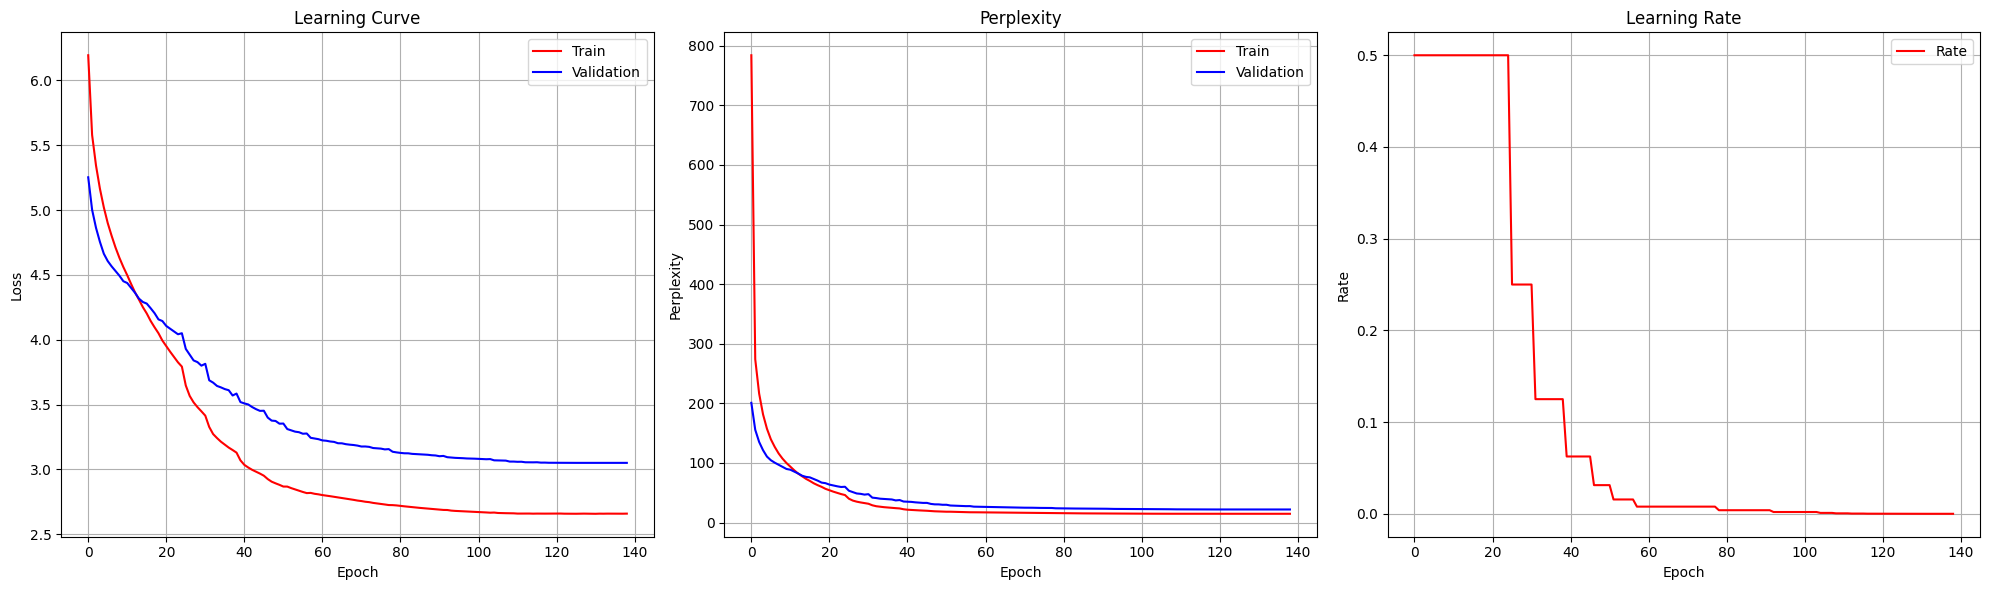

In [24]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 3.05 , Perplexity = 21.98
Test: Loss = 2.946 , Perplexity = 20.39


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

In [22]:
num_trainable_params(model)

39.309264

In [134]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.9, 
                          model = model)

print(generated_text)

i think the movie becomes clearly different .
